世界の人口GDP情報は引っこ抜きたい。
https://www.stat.go.jp/data/sekai/qa-1.html#qapopdb

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install japanize_matplotlib
!pip install optuna
import japanize_matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import optuna.integration.lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
STUDY_EDA = False
DEBUG = False

input_path = '/content/drive/MyDrive/input/signate/sony_competition/'
output_path = '/content/drive/MyDrive/output/signate/sony_competition/'
interm_path = '/content/drive/MyDrive/intermediate/signate/sony_competition/'
now = dt.datetime.today()
month = str(now.month)
day = str(now.day)
comment = 'sony_competition'

save_nm = f'submission_{comment}_{month}_{day}.csv'
print(save_nm)

submission_sony_competition_4_16.csv


In [4]:
train_df = pd.read_csv(input_path + 'train.csv')
test_df = pd.read_csv(input_path + 'test.csv')

In [5]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,90,1.917,14.141,38.374,304.731,50,2.957,3.230,14.056,25.630,176,14.959,17.471,24.221,20.883,101,16.423,19.819,20.044,3.188,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,10.898,52,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,83,0.349,2.349,38.600,353.549,47,0.422,5.794,9.972,9.234,80,14.911,21.140,32.584,74.298,55,10.297,11.822,13.377,2.311,155,51.918,76.736,96.533,484.188,124,1019.521,1022.992,1027.611,15.142,102,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063


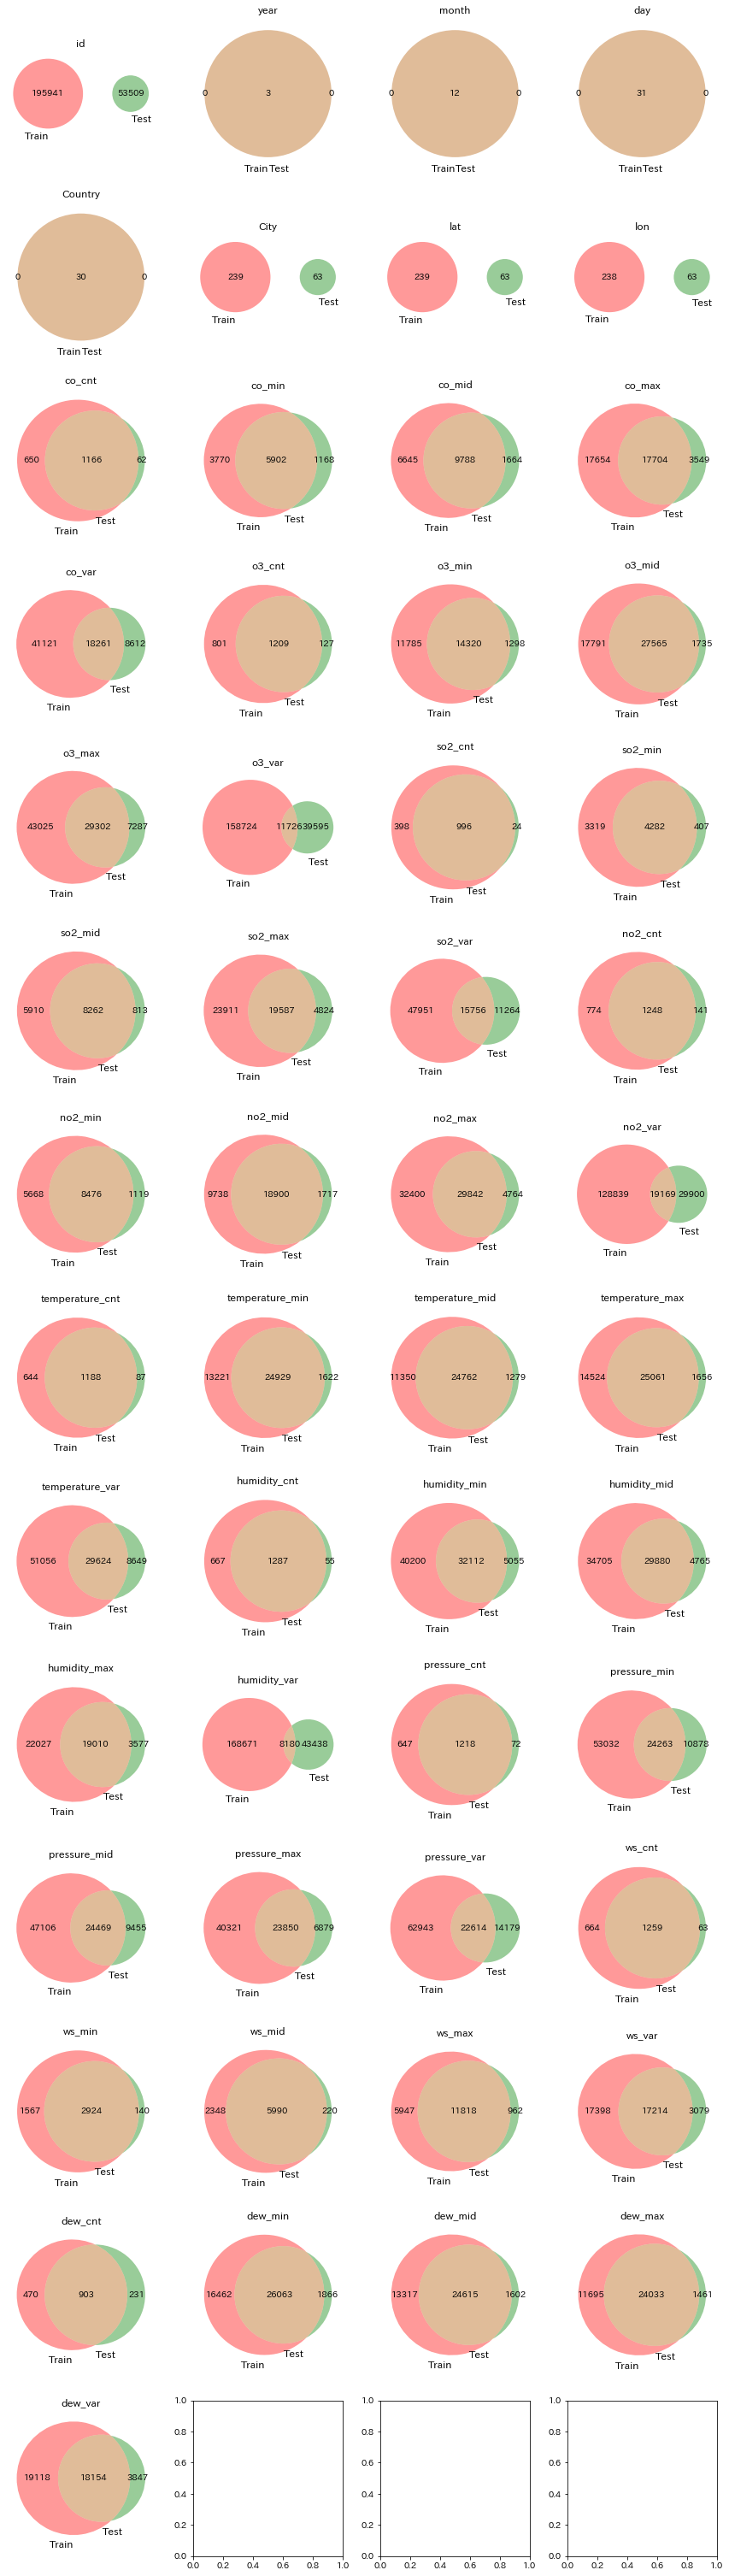

In [6]:
from matplotlib_venn import venn2
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [7]:
for col_nm in train_df.columns:
    print(col_nm)
    print(train_df[col_nm].dtype)
    print(train_df[col_nm].nunique())
    print(train_df[col_nm].unique())

    print('*'*80)
    print('*'*80)
    print('*'*80)

id
int64
195941
[     1      2      3 ... 195939 195940 195941]
********************************************************************************
********************************************************************************
********************************************************************************
year
int64
3
[2019 2020 2021]
********************************************************************************
********************************************************************************
********************************************************************************
month
int64
12
[ 1  2  3  4  5  6  7  8  9 10 11 12]
********************************************************************************
********************************************************************************
********************************************************************************
day
int64
31
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
***************

In [8]:
train_df.isnull().sum()

id                 0
year               0
month              0
day                0
Country            0
City               0
lat                0
lon                0
co_cnt             0
co_min             0
co_mid             0
co_max             0
co_var             0
o3_cnt             0
o3_min             0
o3_mid             0
o3_max             0
o3_var             0
so2_cnt            0
so2_min            0
so2_mid            0
so2_max            0
so2_var            0
no2_cnt            0
no2_min            0
no2_mid            0
no2_max            0
no2_var            0
temperature_cnt    0
temperature_min    0
temperature_mid    0
temperature_max    0
temperature_var    0
humidity_cnt       0
humidity_min       0
humidity_mid       0
humidity_max       0
humidity_var       0
pressure_cnt       0
pressure_min       0
pressure_mid       0
pressure_max       0
pressure_var       0
ws_cnt             0
ws_min             0
ws_mid             0
ws_max             0
ws_var       

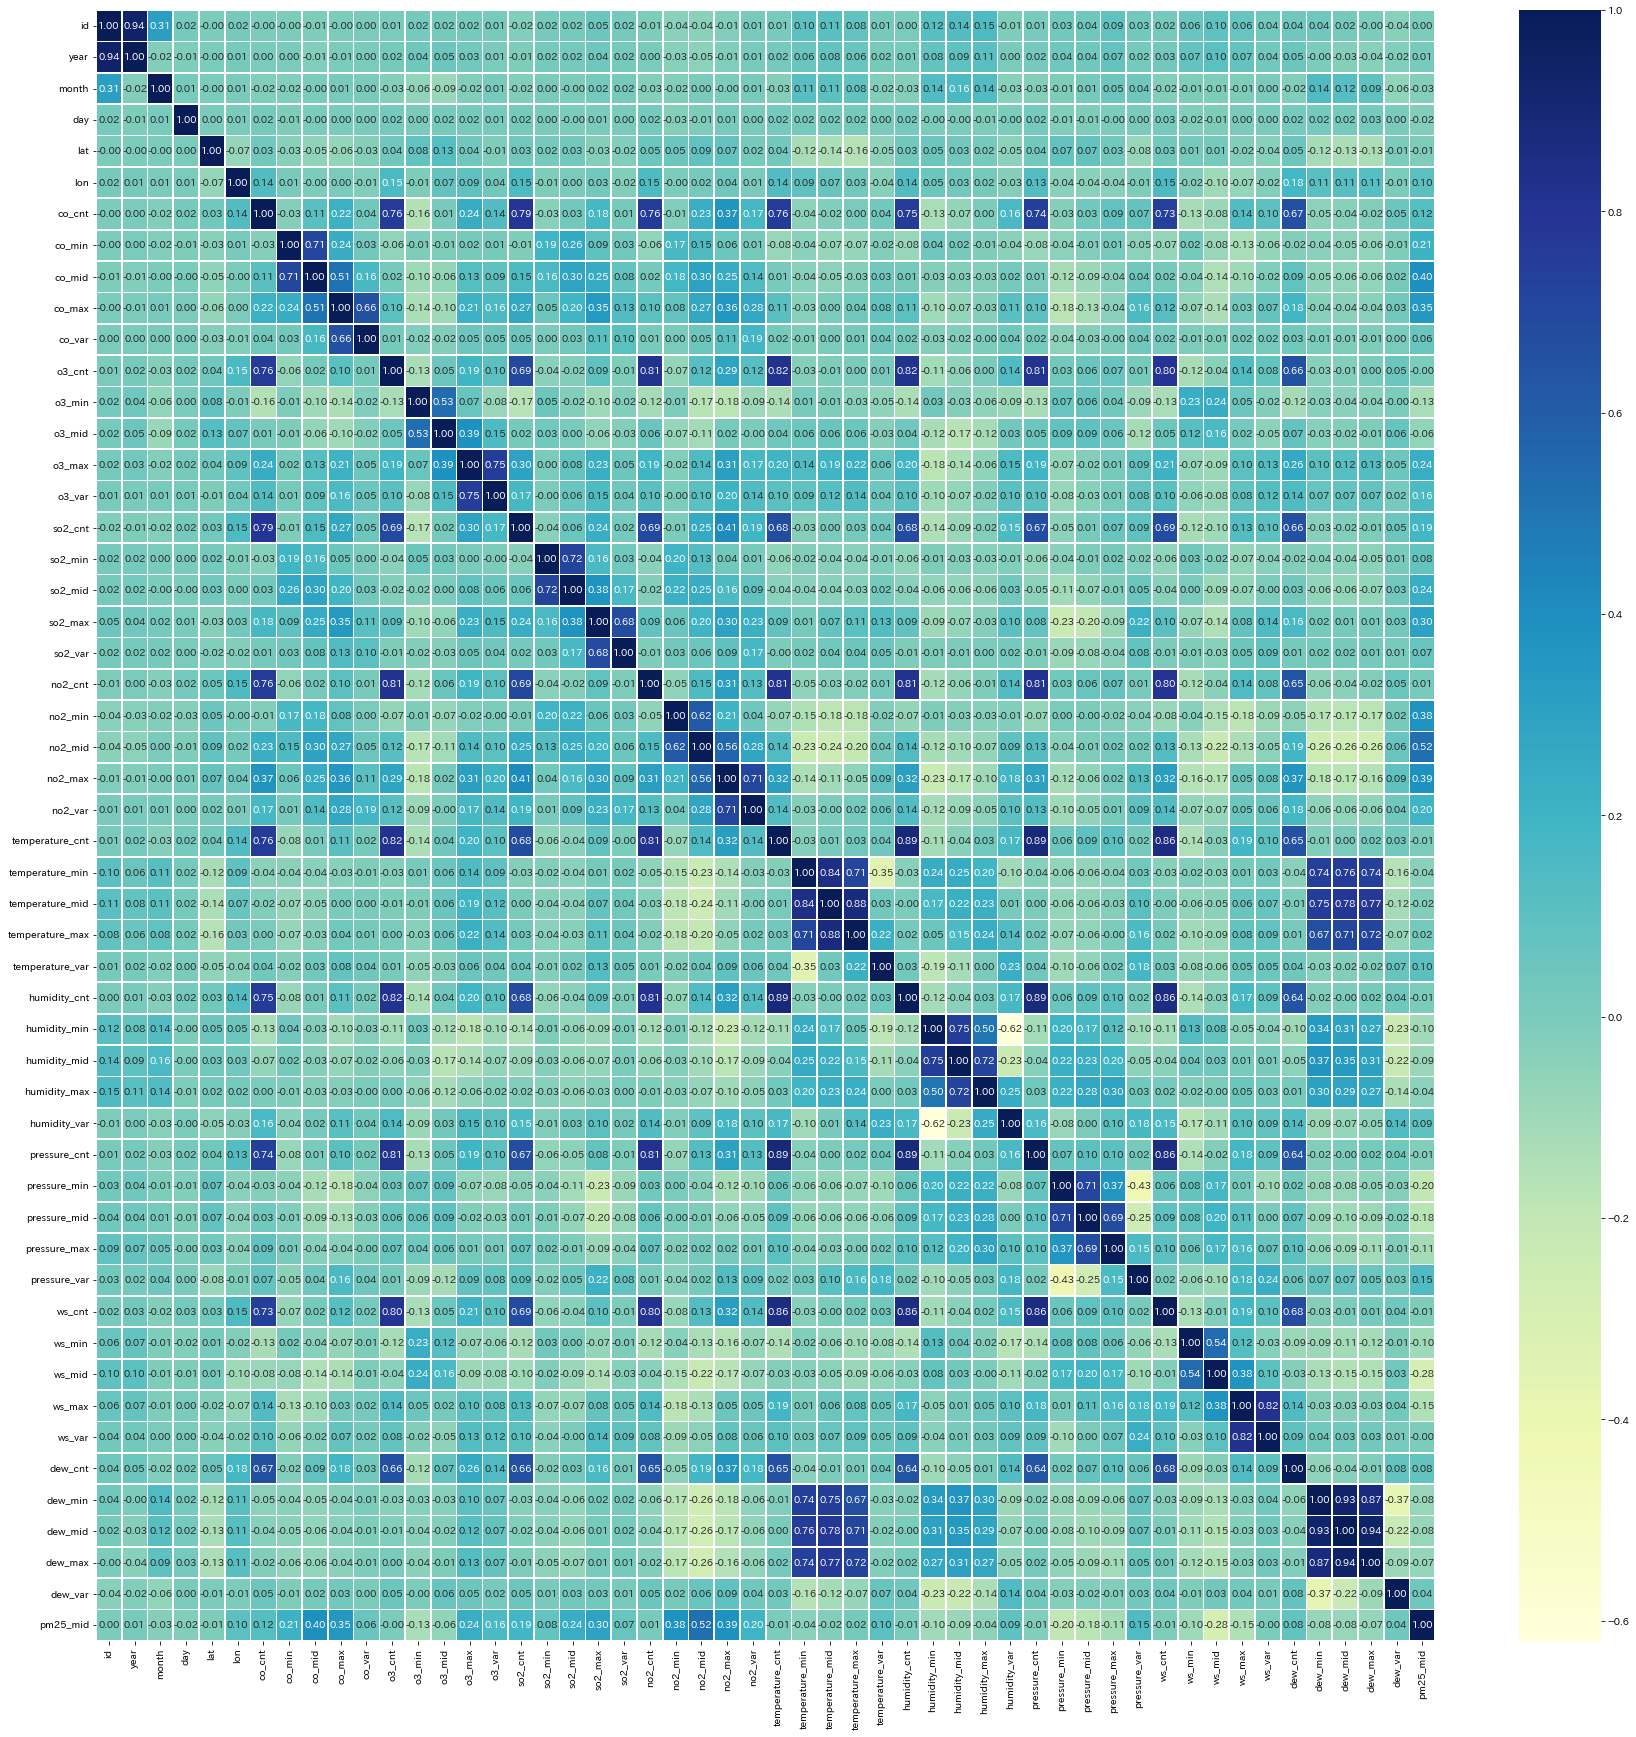

In [9]:
plt.figure(figsize = (30, 30))
sns.heatmap(train_df.corr(), fmt="1.2f", annot=True, lw=0.7, cmap='YlGnBu')

In [10]:
train_df.groupby('Country')['pm25_mid'].mean().reset_index(drop = False).sort_values('pm25_mid', ascending = False)

,Country,pm25_mid
11,India,96.922864
6,China,73.915095
2,Bosnia and Herzegovina,66.000577
25,Thailand,61.916089
20,Serbia,61.116688
26,Turkey,60.981304
13,Israel,59.996698
21,South Africa,58.512415
22,South Korea,58.455972
16,Mexico,56.501308


# preprocessing

In [11]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
train_test = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)
train_test.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,train_test
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901,train
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741,train
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918,train
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,90,1.917,14.141,38.374,304.731,50,2.957,3.230,14.056,25.630,176,14.959,17.471,24.221,20.883,101,16.423,19.819,20.044,3.188,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,10.898,52,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370,train
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,83,0.349,2.349,38.600,353.549,47,0.422,5.794,9.972,9.234,80,14.911,21.140,32.584,74.298,55,10.297,11.822,13.377,2.311,155,51.918,76.736,96.533,484.188,124,1019.521,1022.992,1027.611,15.142,102,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063,train


In [12]:
train_test['date'] = train_test['year'].astype(str).str.zfill(4) + train_test['month'].astype(str).str.zfill(2) + train_test['day'].astype(str).str.zfill(2)
train_test['date'] = pd.to_datetime(train_test['date'])
train_test['dow'] = train_test['date'].dt.dayofweek
# train_test = train_test.drop(columns = ['year', 'month', 'day'])
train_test.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,train_test,date,dow
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901,train,2019-01-01,1
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741,train,2019-01-01,1
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918,train,2019-01-01,1
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,90,1.917,14.141,38.374,304.731,50,2.957,3.230,14.056,25.630,176,14.959,17.471,24.221,20.883,101,16.423,19.819,20.044,3.188,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,10.898,52,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370,train,2019-01-01,1
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,83,0.349,2.349,38.600,353.549,47,0.422,5.794,9.972,9.234,80,14.911,21.140,32.584,74.298,55,10.297,11.822,13.377,2.311,155,51.918,76.736,96.533,484.188,124,1019.521,1022.992,1027.611,15.142,102,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063,train,2019-01-01,1


In [13]:
def grouping_describe(df, key_describe_cols, stat_describe_cols, agg_describe_kinds):
      
    """
    統計値を取得する

    Args:
        df(DataFrame):前処理するデータ
        key_describe_cols(list):groupbyするキー
        stat_describe_cols(list):groupbyされるキー
        agg_describe_kinds(list):統計リスト
        
    Returns:
        df(DataFrame)
        
    """  
        
    for key_col, agg_kind, stat_col in itertools.product(key_describe_cols, agg_describe_kinds, stat_describe_cols):
        
        df[stat_col + '_' + agg_kind + '_by_' + key_col] = df.groupby([key_col])[stat_col].transform(agg_kind)

    display(df.head())
        
    return df

In [14]:
train_test.columns.tolist()

['id',
 'year',
 'month',
 'day',
 'Country',
 'City',
 'lat',
 'lon',
 'co_cnt',
 'co_min',
 'co_mid',
 'co_max',
 'co_var',
 'o3_cnt',
 'o3_min',
 'o3_mid',
 'o3_max',
 'o3_var',
 'so2_cnt',
 'so2_min',
 'so2_mid',
 'so2_max',
 'so2_var',
 'no2_cnt',
 'no2_min',
 'no2_mid',
 'no2_max',
 'no2_var',
 'temperature_cnt',
 'temperature_min',
 'temperature_mid',
 'temperature_max',
 'temperature_var',
 'humidity_cnt',
 'humidity_min',
 'humidity_mid',
 'humidity_max',
 'humidity_var',
 'pressure_cnt',
 'pressure_min',
 'pressure_mid',
 'pressure_max',
 'pressure_var',
 'ws_cnt',
 'ws_min',
 'ws_mid',
 'ws_max',
 'ws_var',
 'dew_cnt',
 'dew_min',
 'dew_mid',
 'dew_max',
 'dew_var',
 'pm25_mid',
 'train_test',
 'date',
 'dow']

In [15]:
print('***********************************************************************************')
print('preprocessing...grouping_describe')

key_describe_cols = [
    'Country',
    'City'
]

stat_describe_cols = [
    'co_cnt',
    'co_min',
    'co_mid',
    'co_max',
    'co_var',
    'o3_cnt',
    'o3_min',
    'o3_mid',
    'o3_max',
    'o3_var',
    'so2_cnt',
    'so2_min',
    'so2_mid',
    'so2_max',
    'so2_var',
    'no2_cnt',
    'no2_min',
    'no2_mid',
    'no2_max',
    'no2_var',
    'temperature_cnt',
    'temperature_min',
    'temperature_mid',
    'temperature_max',
    'temperature_var',
    'humidity_cnt',
    'humidity_min',
    'humidity_mid',
    'humidity_max',
    'humidity_var',
    'pressure_cnt',
    'pressure_min',
    'pressure_mid',
    'pressure_max',
    'pressure_var',
    'ws_cnt',
    'ws_min',
    'ws_mid',
    'ws_max',
    'ws_var',
    'dew_cnt',
    'dew_min',
    'dew_mid',
    'dew_max',
    'dew_var'
]

agg_describe_kinds = [
    'mean',
    'std'
]

preprocessed_train_test_df = grouping_describe(train_test, key_describe_cols, stat_describe_cols, agg_describe_kinds)

print('finished')
print('***********************************************************************************')

***********************************************************************************
preprocessing...grouping_describe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,...,dew_cnt_mean_by_City,dew_min_mean_by_City,dew_mid_mean_by_City,dew_max_mean_by_City,dew_var_mean_by_City,co_cnt_std_by_City,co_min_std_by_City,co_mid_std_by_City,co_max_std_by_City,co_var_std_by_City,o3_cnt_std_by_City,o3_min_std_by_City,o3_mid_std_by_City,o3_max_std_by_City,o3_var_std_by_City,so2_cnt_std_by_City,so2_min_std_by_City,so2_mid_std_by_City,so2_max_std_by_City,so2_var_std_by_City,no2_cnt_std_by_City,no2_min_std_by_City,no2_mid_std_by_City,no2_max_std_by_City,no2_var_std_by_City,temperature_cnt_std_by_City,temperature_min_std_by_City,temperature_mid_std_by_City,temperature_max_std_by_City,temperature_var_std_by_City,humidity_cnt_std_by_City,humidity_min_std_by_City,humidity_mid_std_by_City,humidity_max_std_by_City,humidity_var_std_by_City,pressure_cnt_std_by_City,pressure_min_std_by_City,pressure_mid_std_by_City,pressure_max_std_by_City,pressure_var_std_by_City,ws_cnt_std_by_City,ws_min_std_by_City,ws_mid_std_by_City,ws_max_std_by_City,ws_var_std_by_City,dew_cnt_std_by_City,dew_min_std_by_City,dew_mid_std_by_City,dew_max_std_by_City,dew_var_std_by_City
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,...,86.610505,10.539171,13.691912,16.817464,10.123624,75.156953,0.970611,3.044513,7.985686,238.595292,137.325237,3.957698,9.482628,18.085160,277.401074,62.871043,0.577047,1.421097,12.975860,750.565355,176.764095,1.755914,4.389903,11.598978,86.995818,112.641640,8.331567,8.321862,9.661201,71.332366,121.319544,20.247014,24.181223,10.179049,560.016922,115.337957,35.859241,26.673841,28.265105,398.503230,124.535044,0.438300,1.207808,3.372932,20.622297,78.730389,8.206793,7.110598,6.511316,15.127626
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,...,72.319773,14.118159,17.981105,21.191872,13.377982,69.566823,1.466033,2.054405,24.015607,2593.565935,148.686397,4.994708,9.565684,22.775043,1074.075258,71.070212,0.725184,1.377973,6.971266,30.380643,143.794187,1.702460,4.296698,11.011243,78.220847,126.252408,8.204760,7.397379,7.234904,29.620243,142.635590,17.433511,15.260344,11.975060,363.069560,153.852055,40.563799,31.045361,29.469108,372.880213,136.330604,0.546090,1.103215,8.485075,103.083587,83.169266,9.157340,7.582795,6.376237,23.272279
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,...,73.701349,6.773539,9.971839,13.228287,9.346276,87.941560,0.988102,1.869471,4.395733,10.661286,150.724301,5.191014,8.272747,15.305237,278.928611,79.939860,0.872296,1.537645,6.884163,39.716774,157.186548,1.854029,4.524876,11.238750,91.643078,131.250835,7.650568,7.870683,7.804867,42.518350,137.377568,18.225384,15.309873,11.341258,404.982235,164.770356,43.938502,41.376423,28.462157,1419.777235,146.999283,0.581874,1.444781,3.107642,11.226975,81.241876,7.606184,6.965281,6.715487,10.071975
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,

finished
***********************************************************************************


# 人口追加

In [16]:
population_df = pd.read_excel(input_path + 'WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx', sheet_name = 'ESTIMATES')

In [17]:
population_df = population_df[[
    'Region, subregion, country or area *',
    '1950',
    '1951',
    '1952',
    '1953',
    '1954',
    '1955',
    '1956',
    '1957',
    '1958',
    '1959',
    '1960',
    '1961',
    '1962',
    '1963',
    '1964',
    '1965',
    '1966',
    '1967',
    '1968',
    '1969',
    '1970',
    '1971',
    '1972',
    '1973',
    '1974',
    '1975',
    '1976',
    '1977',
    '1978',
    '1979',
    '1980',
    '1981',
    '1982',
    '1983',
    '1984',
    '1985',
    '1986',
    '1987',
    '1988',
    '1989',
    '1990',
    '1991',
    '1992',
    '1993',
    '1994',
    '1995',
    '1996',
    '1997',
    '1998',
    '1999',
    '2000',
    '2001',
    '2002',
    '2003',
    '2004',
    '2005',
    '2006',
    '2007',
    '2008',
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
    '2019',
    '2020'
 ]].rename(columns = {'Region, subregion, country or area *':'Country'})

In [18]:
change_country_dict = {
    'Iran (Islamic Republic of)':'Iran',
    'Russian Federation':'Russia',
    'Republic of Korea':'South Korea',
    'China, Taiwan Province of China':'Taiwan',
    'United States of America':'United States',
    'Viet Nam':'Vietnam'
 }

population_df['Country'] = population_df['Country'].replace(change_country_dict)

In [19]:
print(preprocessed_train_test_df.shape)
preprocessed_train_test_df = pd.merge(
    preprocessed_train_test_df,
    population_df,
    on = 'Country',
    how = 'left'
)
print(preprocessed_train_test_df.shape)
display(preprocessed_train_test_df.head())

(249450, 237)
(249450, 308)


,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,...,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,...,13033.13,13244.163,13431.79,13605.574,13773.29,13935.722,14092.545,14249.403,14413.002,14588.4,14777.241,14979.203,15194.644,15423.156,15663.672,15917.58,16183.159,16452.258,16713.989,16960.6,17189.235,17402.179,17603.211,17798.526,17993.083,18189.274,18387.205,18587.027,18788.187,18991.434,19194.676,19401.366,19624.163,19879.654,20178.543,20526.3,20916.339,21332.293,21750.852,22154.687,22538.002,22903.951,23254.912,23596.426,23932.499,24262.71,24584.619,24898.153,25203.2,25499.881
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,...,13033.13,13244.163,13431.79,13605.574,13773.29,13935.722,14092.545,14249.403,14413.002,14588.4,14777.241,14979.203,15194.644,15423.156,15663.672,15917.58,16183.159,16452.258,16713.989,16960.6,17189.235,17402.179,17603.211,17798.526,17993.083,18189.274,18387.205,18587.027,18788.187,18991.434,19194.676,19401.366,19624.163,19879.654,20178.543,20526.3,20916.339,21332.293,21750.852,22154.687,22538.002,22903.951,23254.912,23596.426,23932.499,24262.71,24584.619,24898.153,25203.2,25499.881
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,...,13033.13,13244.163,13431.79,13605.574,13773.29,13935.722,14092.545,14249.403,14413.002,14588.4,14777.241,14979.203,15194.644,15423.156,15663.672,15917.58,16183.159,16452.258,16713.989,16960.6,17189.235,17402.179,17603.211,17798.526,17993.083,18189.274,18387.205,18587.027,18788.187,18991.434,19194.676,19401.366,19624.163,19879.654,20178.543,20526.3,20916.339,21332.293,21750.852,22154.687,22538.002,22903.951,23254.912,23596.426,23932.499,24262.71,24584.619,24898.153,25203.2,25499.881
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,90,1.917,14.141,38.374,304.731,50,2.957,3.230,14.056,25.630,176,14.959,17.471,24.221,20.883,101,16.423,19.819,20.044,3.188,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,10.898,52,0.284,0.503,3.592,2.485,116,7.146,...,13033.13,13244.163,13431.79,13605.574,13773.29,13935.722,14092.545,14249.403,14413.002,14588.4,14777.241,14979.203,15194.644,15423.156,15663.672,15917.58,16183.159,16452.258,16713.989,16960.6,17189.235,17402.179,17603.211,17798.526,17993.083,18189.274,18387.205,18587.027,18788.187,18991.434,19194.676,19401.366,19624.163,19879.654,20178.543,20526.3,20916.339,21332.293,21750.852,22154.687,22538.002,22903.951,23254.912,23596.426,23932.499,24262.71,24584.619,24898.153,25203.2,25499.881
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,83,0.349,2.349,38.600,353.549,4

In [20]:
preprocessed_train_test_df['2010_2020'] = preprocessed_train_test_df['2020'] - preprocessed_train_test_df['2010']
preprocessed_train_test_df['2000_2010'] = preprocessed_train_test_df['2010'] - preprocessed_train_test_df['2000']
preprocessed_train_test_df['1990_2000'] = preprocessed_train_test_df['2000'] - preprocessed_train_test_df['1990']
preprocessed_train_test_df['1980_1990'] = preprocessed_train_test_df['1990'] - preprocessed_train_test_df['1980']
preprocessed_train_test_df['1970_1980'] = preprocessed_train_test_df['1980'] - preprocessed_train_test_df['1970']
preprocessed_train_test_df['1960_1970'] = preprocessed_train_test_df['1970'] - preprocessed_train_test_df['1960']
preprocessed_train_test_df['1950_1960'] = preprocessed_train_test_df['1960'] - preprocessed_train_test_df['1950']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

# モデル

In [21]:
label_cols = [
    'Country',
    'City'
]

for label_col in label_cols:
    le = LabelEncoder()
    preprocessed_train_test_df[label_col] = le.fit_transform(preprocessed_train_test_df[label_col])


In [22]:
target = 'pm25_mid'

preprocessed_train_df = preprocessed_train_test_df[preprocessed_train_test_df['train_test'] == 'train'].drop(columns = ['train_test', 'id']).reset_index(drop = True)
preprocessed_train_df = preprocessed_train_df.sort_values('date').drop(columns = ['date']).reset_index(drop = True)
preprocessed_test_df = preprocessed_train_test_df[preprocessed_train_test_df['train_test'] == 'test'].drop(columns = ['train_test', 'id', 'date', target]).reset_index(drop = True)

x = preprocessed_train_df.drop(columns = target)
y = preprocessed_train_df[target]

In [23]:
# foldデータ作成
from sklearn.model_selection import TimeSeriesSplit
fold = TimeSeriesSplit(n_splits=5)
cv = list(fold.split(x, y))

In [24]:
print(cv)

[(array([    0,     1,     2, ..., 32658, 32659, 32660]), array([32661, 32662, 32663, ..., 65314, 65315, 65316])), (array([    0,     1,     2, ..., 65314, 65315, 65316]), array([65317, 65318, 65319, ..., 97970, 97971, 97972])), (array([    0,     1,     2, ..., 97970, 97971, 97972]), array([ 97973,  97974,  97975, ..., 130626, 130627, 130628])), (array([     0,      1,      2, ..., 130626, 130627, 130628]), array([130629, 130630, 130631, ..., 163282, 163283, 163284])), (array([     0,      1,      2, ..., 163282, 163283, 163284]), array([163285, 163286, 163287, ..., 195938, 195939, 195940]))]


In [25]:
def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 50000,
            verbose_eval = False,
            early_stopping_rounds = 100
        )

        
        oof_pred = model.predict(x_valid)
        score = np.sqrt(mse(oof_pred, y_valid))

        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print(f'fold{i+1}finished')
        print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        scores_lgbm.append(score)
        
    return oofs_lgbm, models_lgbm, scores_lgbm

params = {
    'objective':'regression',
    'metric':'rmse'
}

oofs_lgbm, models_lgbm, scores_lgbm = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

[I 2022-04-16 09:35:01,089] A new study created in memory with name: no-name-105b3d2d-4937-4e24-8d7d-c9ce94d09b7f
min_data_in_leaf, val_score: 21.415380: 100%|##########| 5/5 [00:52<00:00, 10.60s/it]


**************************************************
**************************************************
**************************************************
fold1finished
rmse: 21.415379671803468
**************************************************
**************************************************
**************************************************


[I 2022-04-16 09:46:42,546] A new study created in memory with name: no-name-540979f9-7baf-4651-9d23-5ad2c5ae423a
min_data_in_leaf, val_score: 22.105689: 100%|##########| 5/5 [03:08<00:00, 37.75s/it]


**************************************************
**************************************************
**************************************************
fold2finished
rmse: 22.105688709454636
**************************************************
**************************************************
**************************************************


[I 2022-04-16 10:22:16,776] A new study created in memory with name: no-name-3680334f-adf4-4c93-aa17-5fe216ef5a5d
min_data_in_leaf, val_score: 19.111605: 100%|##########| 5/5 [02:28<00:00, 29.79s/it]


**************************************************
**************************************************
**************************************************
fold3finished
rmse: 19.111604890970106
**************************************************
**************************************************
**************************************************


[I 2022-04-16 10:53:59,040] A new study created in memory with name: no-name-a59bca2a-e006-4100-8e98-0afb16dd9f3f
min_data_in_leaf, val_score: 21.835019: 100%|##########| 5/5 [03:29<00:00, 41.89s/it]


**************************************************
**************************************************
**************************************************
fold4finished
rmse: 21.835019261363403
**************************************************
**************************************************
**************************************************


[I 2022-04-16 11:40:20,145] A new study created in memory with name: no-name-9a77ef7c-6a1f-49cb-bd78-545ccd7e056e
min_data_in_leaf, val_score: 18.912402: 100%|##########| 5/5 [04:50<00:00, 58.20s/it]


**************************************************
**************************************************
**************************************************
fold5finished
rmse: 18.912402440788384
**************************************************
**************************************************
**************************************************


In [26]:
print(np.mean(scores_lgbm))

20.676018994876


In [27]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

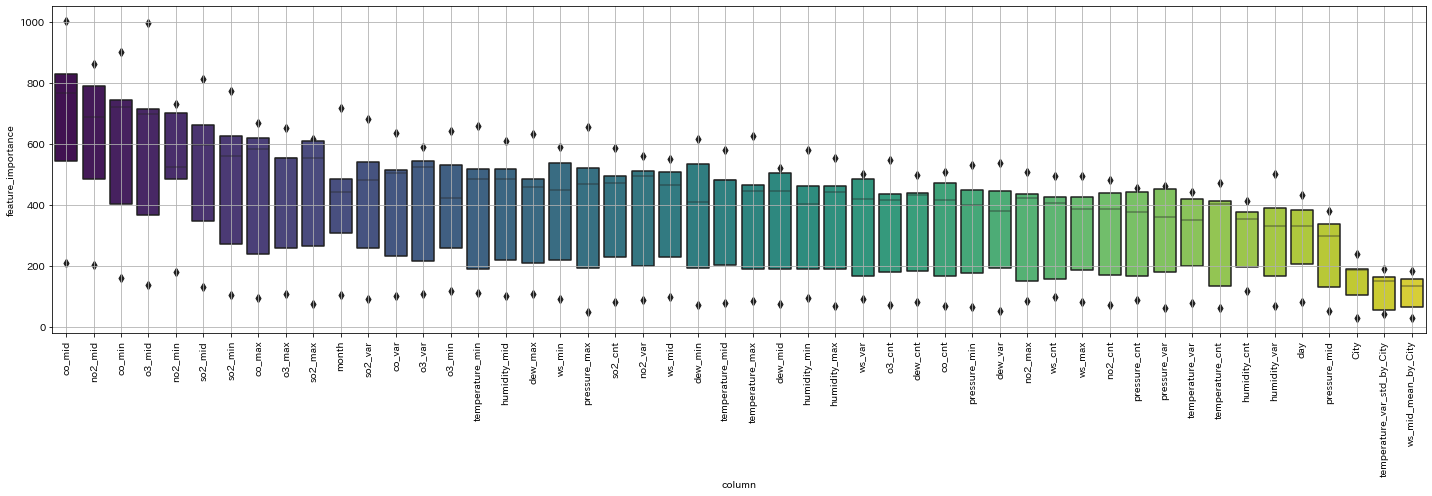

In [28]:
fig, ax = visualize_importance(models_lgbm, x)

In [29]:
y_pred_lgbm = np.array([model.predict(preprocessed_test_df.values) for model in models_lgbm])
y_pred_lgbm = np.mean(y_pred_lgbm, axis=0)

In [30]:
print(np.array([model.params for model in models_lgbm]))

[{'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.019434983069936615, 'lambda_l2': 8.989980241445051e-08, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.8206644699541673, 'bagging_freq': 2, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.03461252435167848, 'lambda_l2': 9.930786644283327, 'num_leaves': 13, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 6.588353260939228, 'lambda_l2': 0.06946840622166076, 'num_leaves': 39, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 3.360005931228633e-08, 'lambda_l2': 0.0016647989797646371, 'num_leaves': 90, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, '

In [31]:
y_pred_lgbm

array([22.57092306, 35.29713803, 27.00779611, ..., 70.16532813,
       33.56184432, 33.43538715])

In [32]:
sample_submission_df = pd.read_csv(input_path + 'submit_sample.csv', header = None)
print(sample_submission_df.shape)
sample_submission_df.head()

(53509, 2)


,0,1
0,195942,54.321
1,195943,54.321
2,195944,54.321
3,195945,54.321
4,195946,54.321


In [33]:
len(y_pred_lgbm)

53509

In [34]:
sample_submission_df[1] = y_pred_lgbm
sample_submission_df.head()

,0,1
0,195942,22.570923
1,195943,35.297138
2,195944,27.007796
3,195945,59.606573
4,195946,127.993169


In [35]:
sample_submission_df.to_csv(output_path + save_nm, index = False, header = False)